# Import Required Libraries
Import necessary libraries such as pandas, numpy, scikit-learn, and matplotlib for data manipulation, analysis, and modeling.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.feature_selection import VarianceThreshold

## Load and Explore Data
Load the customer segmentation dataset and perform initial exploration.

In [2]:
# Load the dataset
df = pd.read_csv('customer_segmentation.csv', encoding='latin1')

# Display basic info
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData types:")
print(df.dtypes)
print("\nFirst few rows:")
df.head()

Dataset shape: (541909, 8)

Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

Data types:
InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

First few rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Basic statistical summary
print("Statistical Summary:")
print(df.describe())

Statistical Summary:
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


## Data Preprocessing
Clean the data, handle missing values, convert dates, and calculate total spend per transaction.

In [4]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Calculate total spend per transaction
df['TotalSpend'] = df['Quantity'] * df['UnitPrice']

# Filter out negative quantities (returns)
df = df[df['Quantity'] > 0]

# Display processed data info
print("Processed dataset shape:", df.shape)
print("\nDate range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())
df.head()

Missing values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Processed dataset shape: (397924, 9)

Date range: 2010-12-01 08:26:00 to 2011-12-09 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSpend
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


## Data Exploration & Visualization
Explore the preprocessed data through statistical summaries and visualizations to understand distributions and relationships.

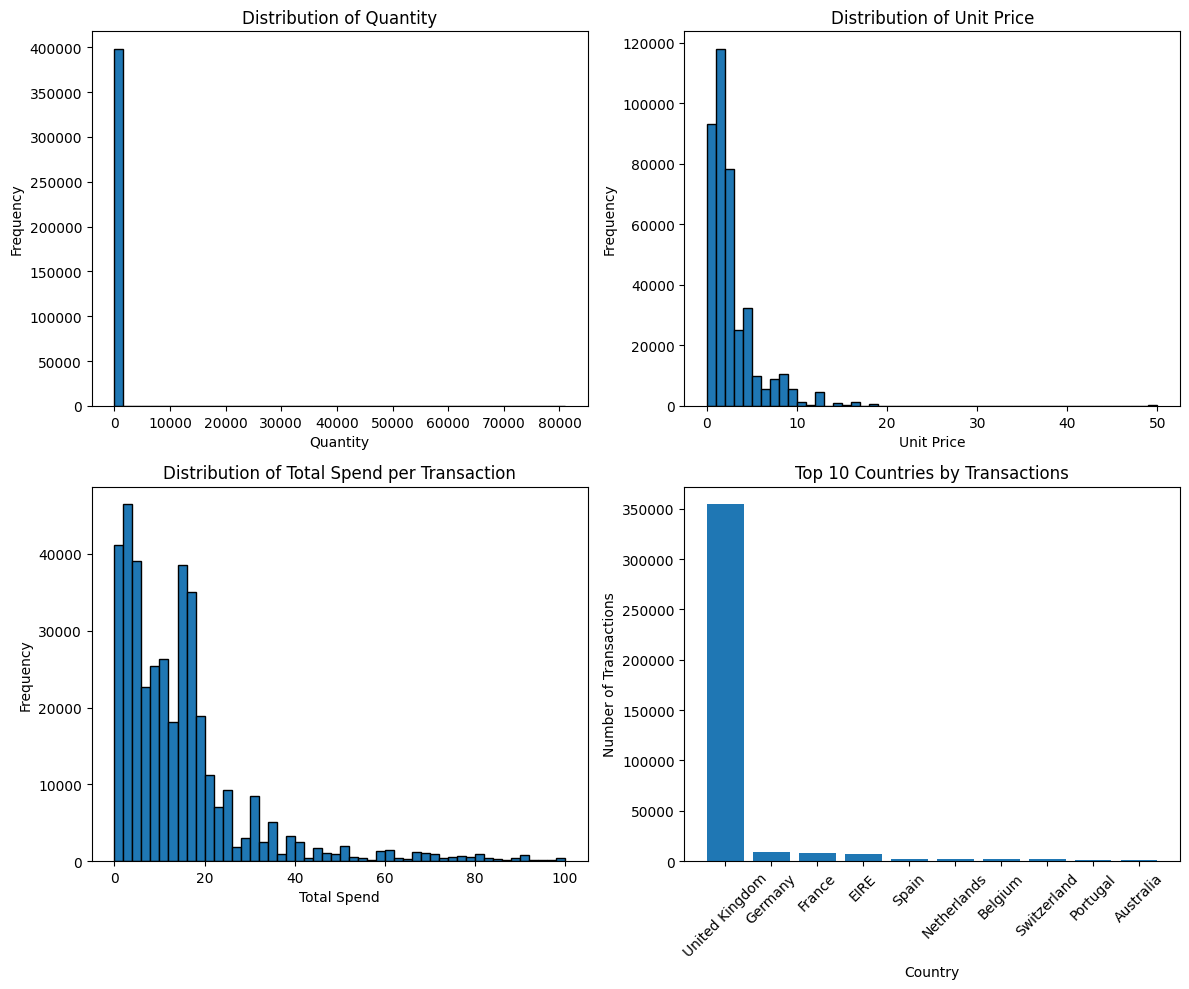

In [5]:
# Distribution of key variables
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Quantity distribution
axes[0,0].hist(df['Quantity'], bins=50, edgecolor='black')
axes[0,0].set_title('Distribution of Quantity')
axes[0,0].set_xlabel('Quantity')
axes[0,0].set_ylabel('Frequency')

# UnitPrice distribution
axes[0,1].hist(df['UnitPrice'], bins=50, edgecolor='black', range=(0, 50))
axes[0,1].set_title('Distribution of Unit Price')
axes[0,1].set_xlabel('Unit Price')
axes[0,1].set_ylabel('Frequency')

# TotalSpend distribution
axes[1,0].hist(df['TotalSpend'], bins=50, edgecolor='black', range=(0, 100))
axes[1,0].set_title('Distribution of Total Spend per Transaction')
axes[1,0].set_xlabel('Total Spend')
axes[1,0].set_ylabel('Frequency')

# Country distribution (top 10)
country_counts = df['Country'].value_counts().head(10)
axes[1,1].bar(country_counts.index, country_counts.values)
axes[1,1].set_title('Top 10 Countries by Transactions')
axes[1,1].set_xlabel('Country')
axes[1,1].set_ylabel('Number of Transactions')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


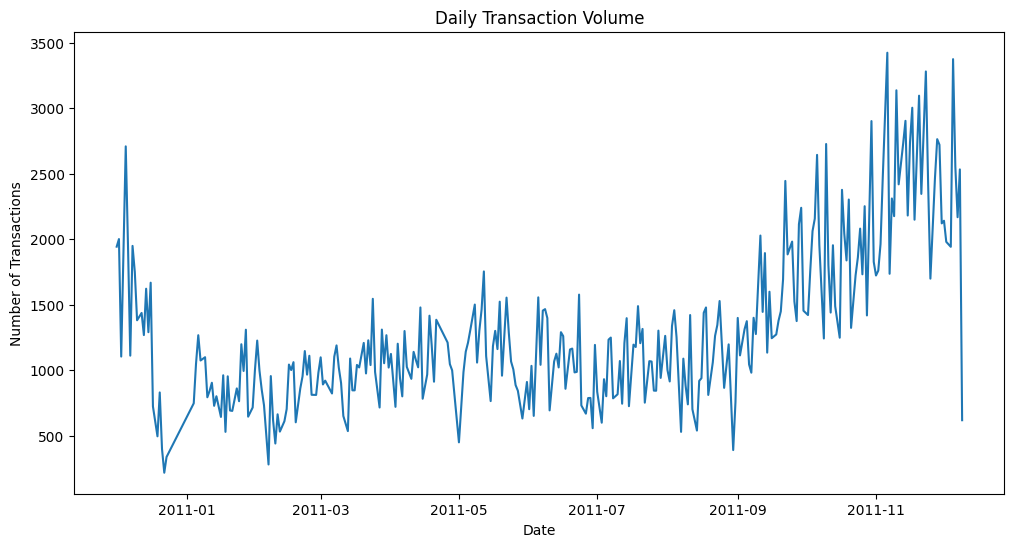

In [6]:
# Time series analysis
df['InvoiceDate'].dt.date.value_counts().sort_index().plot(figsize=(12, 6))
plt.title('Daily Transaction Volume')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.show()

## Aggregation Features
Create customer-level aggregation features such as total spend, frequency, and recency.

In [7]:
# Set reference date (day after last transaction)
reference_date = df['InvoiceDate'].max() + timedelta(days=1)

# Aggregate by customer
customer_agg = df.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max', lambda x: (reference_date - x.max()).days],  # recency
    'InvoiceNo': 'nunique',  # frequency (unique invoices)
    'TotalSpend': 'sum',  # monetary
    'Quantity': 'sum'  # total quantity
}).reset_index()

# Flatten column names
customer_agg.columns = ['CustomerID', 'FirstPurchase', 'LastPurchase', 'Recency', 'Frequency', 'Monetary', 'TotalQuantity']

# Calculate average order value
customer_agg['AvgOrderValue'] = customer_agg['Monetary'] / customer_agg['Frequency']

# Display aggregated data
print("Customer aggregation shape:", customer_agg.shape)
customer_agg.head()

Customer aggregation shape: (4339, 8)


,CustomerID,FirstPurchase,LastPurchase,Recency,Frequency,Monetary,TotalQuantity,AvgOrderValue
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,326,1,77183.60,74215,77183.600000
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,2,7,4310.00,2458,615.714286
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,75,4,1797.24,2341,449.310000
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,19,1,1757.55,631,1757.550000
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,310,1,334.40,197,334.400000


## RFM Analysis
Perform RFM (Recency, Frequency, Monetary) analysis by creating scores for each component.

In [8]:
# Create RFM scores using ranking
# For Recency: lower is better (more recent) - so reverse rank
customer_agg['R_Score'] = pd.qcut(customer_agg['Recency'].rank(method='first'), q=5, labels=[5, 4, 3, 2, 1])

# For Frequency and Monetary: higher is better
customer_agg['F_Score'] = pd.qcut(customer_agg['Frequency'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])
customer_agg['M_Score'] = pd.qcut(customer_agg['Monetary'].rank(method='first'), q=5, labels=[1, 2, 3, 4, 5])

# Combine RFM scores
customer_agg['RFM_Score'] = customer_agg['R_Score'].astype(str) + customer_agg['F_Score'].astype(str) + customer_agg['M_Score'].astype(str)

# Create RFM segments
def rfm_segment(row):
    r, f, m = int(row['R_Score']), int(row['F_Score']), int(row['M_Score'])
    if r >= 4 and f >= 4 and m >= 4:
        return 'Champions'
    elif r >= 3 and f >= 3 and m >= 3:
        return 'Loyal Customers'
    elif r >= 3 and f >= 1 and m >= 1:
        return 'Potential Loyalists'
    elif r >= 2 and f >= 2 and m >= 2:
        return 'Promising'
    elif r >= 2 and f >= 1 and m >= 1:
        return 'Needs Attention'
    else:
        return 'At Risk'

customer_agg['RFM_Segment'] = customer_agg.apply(rfm_segment, axis=1)

# Display RFM results
print("RFM Analysis:")
print(customer_agg['RFM_Segment'].value_counts())
customer_agg.head()

RFM Analysis:
RFM_Segment
Champions              947
Potential Loyalists    895
At Risk                868
Loyal Customers        761
Promising              570
Needs Attention        298
Name: count, dtype: int64


,CustomerID,FirstPurchase,LastPurchase,Recency,Frequency,Monetary,TotalQuantity,AvgOrderValue,R_Score,F_Score,M_Score,RFM_Score,RFM_Segment
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,326,1,77183.60,74215,77183.600000,1,1,5,115,At Risk
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,2,7,4310.00,2458,615.714286,5,5,5,555,Champions
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,75,4,1797.24,2341,449.310000,2,4,4,244,Promising
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,19,1,1757.55,631,1757.550000,4,1,4,414,Potential Loyalists
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,310,1,334.40,197,334.400000,1,1,2,112,At Risk


## Time-based Features
Create features based on time periods, such as monthly spending patterns and purchase intervals.

In [9]:
# Extract month and year from InvoiceDate
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

# Monthly aggregation per customer
monthly_agg = df.groupby(['CustomerID', 'YearMonth']).agg({
    'TotalSpend': 'sum',
    'InvoiceNo': 'nunique',
    'Quantity': 'sum'
}).reset_index()

# Pivot to get monthly spending
monthly_spend = monthly_agg.pivot(index='CustomerID', columns='YearMonth', values='TotalSpend').fillna(0)

# Rename columns
monthly_spend.columns = ['Spend_' + str(col) for col in monthly_spend.columns]

# Merge monthly spending features
customer_features = customer_agg.merge(monthly_spend, left_on='CustomerID', right_index=True, how='left')

# Fill NaN values only for numeric columns
numeric_cols = customer_features.select_dtypes(include=[np.number]).columns
customer_features[numeric_cols] = customer_features[numeric_cols].fillna(0)

# Calculate additional time-based features
spend_cols = [col for col in customer_features.columns if col.startswith('Spend_')]
customer_features['MaxMonthlySpend'] = customer_features[spend_cols].max(axis=1)
customer_features['AvgMonthlySpend'] = customer_features[spend_cols].mean(axis=1)
customer_features['SpendStd'] = customer_features[spend_cols].std(axis=1)

print("Time-based features added. Final feature set shape:", customer_features.shape)
customer_features.head()

Time-based features added. Final feature set shape: (4339, 29)


,CustomerID,FirstPurchase,LastPurchase,Recency,Frequency,Monetary,TotalQuantity,AvgOrderValue,R_Score,F_Score,...,Spend_2011-06,Spend_2011-07,Spend_2011-08,Spend_2011-09,Spend_2011-10,Spend_2011-11,Spend_2011-12,MaxMonthlySpend,AvgMonthlySpend,SpendStd
0,12346.0,2011-01-18 10:01:00,2011-01-18 10:01:00,326,1,77183.60,74215,77183.600000,1,1,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,77183.60,5937.200000,21406.879033
1,12347.0,2010-12-07 14:57:00,2011-12-07 15:52:00,2,7,4310.00,2458,615.714286,5,5,...,382.52,0.0,584.91,0.0,1294.32,0.00,224.82,1294.32,331.538462,400.288802
2,12348.0,2010-12-16 19:09:00,2011-09-25 13:13:00,75,4,1797.24,2341,449.310000,2,4,...,0.00,0.0,0.00,310.0,0.00,0.00,0.00,892.80,138.249231,263.176548
3,12349.0,2011-11-21 09:51:00,2011-11-21 09:51:00,19,1,1757.55,631,1757.550000,4,1,...,0.00,0.0,0.00,0.0,0.00,1757.55,0.00,1757.55,135.196154,487.456665
4,12350.0,2011-02-02 16:01:00,2011-02-02 16:01:00,310,1,334.40,197,334.400000,1,1,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,334.40,25.723077,92.745873


## Feature Engineering

In [10]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, module='sklearn')

# Split data into training and prediction periods
cutoff_date = pd.to_datetime('2011-09-01')

# Features from transactions before cutoff
df_train = df[df['InvoiceDate'] < cutoff_date]

# CLV as total spend after cutoff
df_future = df[df['InvoiceDate'] >= cutoff_date]
future_clv = df_future.groupby('CustomerID')['TotalSpend'].sum().reset_index()
future_clv.columns = ['CustomerID', 'FutureCLV']

# Aggregate features from training period
reference_date = cutoff_date
customer_agg = df_train.groupby('CustomerID').agg({
    'InvoiceDate': ['min', 'max', lambda x: (reference_date - x.max()).days],  # recency
    'InvoiceNo': 'nunique',  # frequency
    'TotalSpend': 'sum',  # monetary
    'Quantity': 'sum'  # total quantity
}).reset_index()

customer_agg.columns = ['CustomerID', 'FirstPurchase', 'LastPurchase', 'Recency', 'Frequency', 'Monetary', 'TotalQuantity']
customer_agg['AvgOrderValue'] = customer_agg['Monetary'] / customer_agg['Frequency']

# Add additional features
customer_agg['Tenure'] = (customer_agg['LastPurchase'] - customer_agg['FirstPurchase']).dt.days
customer_agg['AvgPurchaseInterval'] = customer_agg['Tenure'] / (customer_agg['Frequency'] - 1).clip(lower=1)
customer_agg['MonthFirst'] = customer_agg['FirstPurchase'].dt.month
customer_agg['MonthLast'] = customer_agg['LastPurchase'].dt.month
customer_agg['LogMonetary'] = np.log1p(customer_agg['Monetary'])
customer_agg['LogFrequency'] = np.log1p(customer_agg['Frequency'])
customer_agg['Freq_AOV'] = customer_agg['Frequency'] * customer_agg['AvgOrderValue']

# Unique products per customer
unique_products = df_train.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products.columns = ['CustomerID', 'UniqueProducts']
customer_agg = customer_agg.merge(unique_products, on='CustomerID', how='left').fillna(0)

# Time-based features from training period
df_train = df_train.copy()  # Make a copy to avoid warnings
df_train.loc[:, 'YearMonth'] = df_train['InvoiceDate'].dt.to_period('M')
monthly_agg = df_train.groupby(['CustomerID', 'YearMonth'])['TotalSpend'].sum().reset_index()
monthly_spend = monthly_agg.pivot(index='CustomerID', columns='YearMonth', values='TotalSpend').fillna(0)
monthly_spend.columns = ['Spend_' + str(col) for col in monthly_spend.columns]

# Merge features
customer_features = customer_agg.merge(monthly_spend, left_on='CustomerID', right_index=True, how='left')
customer_features = customer_features.merge(future_clv, on='CustomerID', how='left').fillna(0)

## Preparing Data For Modeling

In [11]:
# Fill NaN
numeric_cols = customer_features.select_dtypes(include=[np.number]).columns
customer_features[numeric_cols] = customer_features[numeric_cols].fillna(0)

# Additional time-based features
spend_cols = [col for col in customer_features.columns if col.startswith('Spend_')]
customer_features['MaxMonthlySpend'] = customer_features[spend_cols].max(axis=1)
customer_features['AvgMonthlySpend'] = customer_features[spend_cols].mean(axis=1)
customer_features['SpendStd'] = customer_features[spend_cols].std(axis=1)

# Prepare for modeling
feature_cols = ['Recency', 'Frequency', 'TotalQuantity', 'AvgOrderValue', 'MaxMonthlySpend', 'AvgMonthlySpend', 'SpendStd']
feature_cols.extend(spend_cols)

X = customer_features[feature_cols]
y = customer_features['FutureCLV']

# Remove customers with no future CLV or no features
valid_idx = (y > 0) & (X.sum(axis=1) > 0)
X = X[valid_idx]
y = y[valid_idx]

# Clean data: remove rows with NaN or infinite values
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]  # Align y with cleaned X

# Remove features with zero variance (constant features)
selector = VarianceThreshold(threshold=0.0)
X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

# Handle outliers by capping extreme values
for col in X.columns:
    if X[col].dtype in ['int64', 'float64']:
        # Cap at 99th percentile
        cap_value = X[col].quantile(0.99)
        X[col] = X[col].clip(upper=cap_value)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Log transform target for training (to handle skewed distribution)
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# --- Feature transforms for skewed numeric columns + robust scaling ---
# Detect highly skewed features (absolute skew > 1) on the training set
skewness = X_train.skew()
skewed_feats = skewness[skewness.abs() > 1].index.tolist()
print(f'Detected {len(skewed_feats)} highly skewed features: {skewed_feats}')

# Copy dataframes to preserve originals
X_train_t = X_train.copy()
X_test_t = X_test.copy()

# Apply a simple rule: if a column is strictly positive, use log1p; otherwise use Yeo-Johnson PowerTransformer
pt_objects = {}  # store PowerTransformer objects for non-positive columns
for col in skewed_feats:
    try:
        if (X_train_t[col] > 0).all():
            # safe to use log1p
            X_train_t[col] = np.log1p(X_train_t[col])
            X_test_t[col] = np.log1p(X_test_t[col])
        else:
            # use Yeo-Johnson which supports zero and negative values
            pt = PowerTransformer(method='yeo-johnson')
            X_train_t[col] = pt.fit_transform(X_train_t[[col]]).flatten()
            X_test_t[col] = pt.transform(X_test_t[[col]]).flatten()
            pt_objects[col] = pt
    except Exception as e:
        print(f'Warning transforming {col}:', e)

# Choose scaler: 'robust' is default because it is less sensitive to outliers; set to 'standard' to use StandardScaler
scaler_choice = 'robust'  # options: 'robust' or 'standard'
if scaler_choice == 'robust':
    scaler = RobustScaler()
else:
    scaler = StandardScaler()

# Fit scaler on the transformed training data and apply to both train/test
X_train_scaled = scaler.fit_transform(X_train_t)
X_test_scaled = scaler.transform(X_test_t)

# Print summaries to verify
print('X_train shape before/after:', X_train.shape, '->', X_train_scaled.shape)
print('Example transformed feature statistics (train):')
print(pd.DataFrame(X_train_scaled, columns=X_train_t.columns).iloc[:, :8].describe().T.head())

Detected 16 highly skewed features: ['Recency', 'Frequency', 'TotalQuantity', 'AvgOrderValue', 'MaxMonthlySpend', 'AvgMonthlySpend', 'SpendStd', 'Spend_2010-12', 'Spend_2011-01', 'Spend_2011-02', 'Spend_2011-03', 'Spend_2011-04', 'Spend_2011-05', 'Spend_2011-06', 'Spend_2011-07', 'Spend_2011-08']
X_train shape before/after: (1561, 16) -> (1561, 16)
Example transformed feature statistics (train):
                  count      mean       std       min       25%  50%  \
Recency          1561.0  0.002470  0.669205 -1.576329 -0.493804  0.0   
Frequency        1561.0  0.022713  0.604781 -0.630930 -0.630930  0.0   
TotalQuantity    1561.0 -0.020550  0.757171 -3.103955 -0.522967  0.0   
AvgOrderValue    1561.0 -0.030987  0.830483 -5.063903 -0.565537  0.0   
MaxMonthlySpend  1561.0  0.049630  0.830268 -4.254410 -0.462645  0.0   

                      75%       max  
Recency          0.506196  1.267242  
Frequency        0.369070  1.878165  
TotalQuantity    0.477033  2.106661  
AvgOrderValue   

## Model Training and Evaluation

In [12]:
# Train model
model = Ridge(alpha=1.0)  # Add regularization to prevent numerical issues
model.fit(X_train_scaled, y_train_log)

# Predictions (transform back from log)
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance (Predicting Future CLV):")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
}).sort_values('Coefficient', ascending=False)

print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))


Model Performance (Predicting Future CLV):
Mean Absolute Error (MAE): 746.42
Mean Squared Error (MSE): 4046861.27
Root Mean Squared Error (RMSE): 2011.68
R² Score: 0.45

Top 10 Feature Importances:
            Feature  Coefficient
1         Frequency     0.725833
4   MaxMonthlySpend     0.595688
3     AvgOrderValue     0.565143
15    Spend_2011-08     0.169071
14    Spend_2011-07     0.140722
7     Spend_2010-12     0.134588
0           Recency     0.104585
13    Spend_2011-06     0.081745
12    Spend_2011-05     0.057045
11    Spend_2011-04     0.046276


In [14]:
# Compare with Random Forest model
from sklearn.ensemble import RandomForestRegressor

print("\n" + "="*50)
print("COMPARING WITH RANDOM FOREST MODEL")
print("="*50)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train_log)

# Predictions
rf_y_pred_log = rf_model.predict(X_test_scaled)
rf_y_pred = np.expm1(rf_y_pred_log)

# Evaluation
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_y_pred)

print("Random Forest Model Performance:")
print(f"Mean Absolute Error (MAE): {rf_mae:.2f}")
print(f"Mean Squared Error (MSE): {rf_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rf_rmse:.2f}")
print(f"R² Score: {rf_r2:.2f}")

# Feature importance for Random Forest
rf_feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Random Forest Feature Importances:")
print(rf_feature_importance.head(10))



COMPARING WITH RANDOM FOREST MODEL
Random Forest Model Performance:
Mean Absolute Error (MAE): 726.03
Mean Squared Error (MSE): 3455557.75
Root Mean Squared Error (RMSE): 1858.91
R² Score: 0.53

Top 10 Random Forest Feature Importances:
            Feature  Importance
5   AvgMonthlySpend    0.410309
6          SpendStd    0.101621
4   MaxMonthlySpend    0.093983
3     AvgOrderValue    0.079156
2     TotalQuantity    0.067276
0           Recency    0.051265
13    Spend_2011-06    0.029851
14    Spend_2011-07    0.024661
15    Spend_2011-08    0.023655
10    Spend_2011-03    0.021970



MODEL COMPARISON SUMMARY
Metric     Ridge        Random Forest   Better Model
------------------------------------------------------------
MAE        746.42       726.03          Random Forest
RMSE       2011.68      1858.91         Random Forest
R²         0.447        0.528           Random Forest


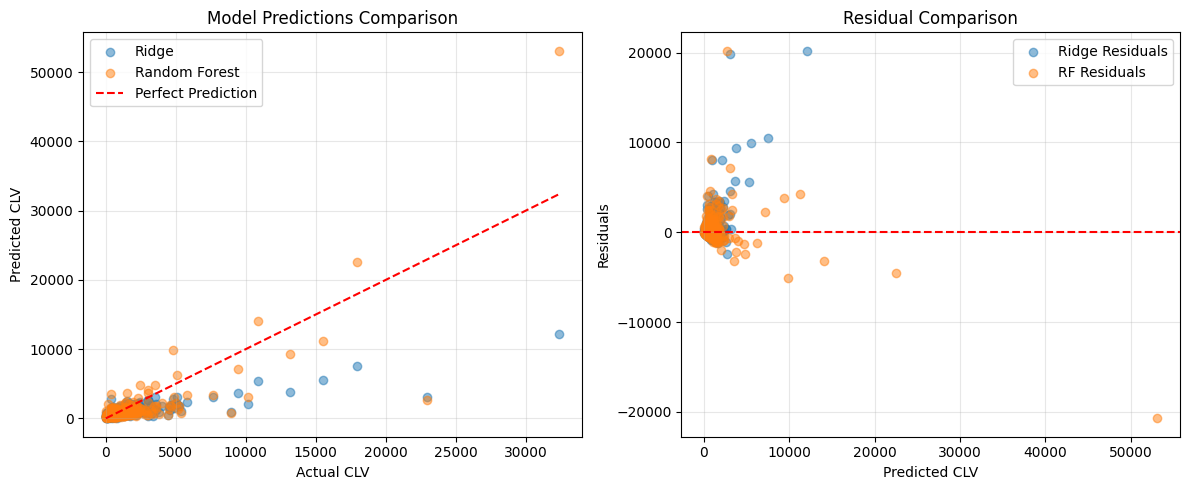

In [15]:
# Model Comparison
print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"{'Metric':<10} {'Ridge':<12} {'Random Forest':<15} {'Better Model'}")
print("-" * 60)
print(f"{'MAE':<10} {mae:<12.2f} {rf_mae:<15.2f} {'Ridge' if mae < rf_mae else 'Random Forest'}")
print(f"{'RMSE':<10} {rmse:<12.2f} {rf_rmse:<15.2f} {'Ridge' if rmse < rf_rmse else 'Random Forest'}")
print(f"{'R²':<10} {r2:<12.3f} {rf_r2:<15.3f} {'Ridge' if r2 > rf_r2 else 'Random Forest'}")

# Visualization comparison
plt.figure(figsize=(12, 5))

# Predicted vs Actual scatter plots
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, label='Ridge')
plt.scatter(y_test, rf_y_pred, alpha=0.5, label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual CLV')
plt.ylabel('Predicted CLV')
plt.title('Model Predictions Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Residual plots
plt.subplot(1, 2, 2)
plt.scatter(y_pred, y_test - y_pred, alpha=0.5, label='Ridge Residuals')
plt.scatter(rf_y_pred, y_test - rf_y_pred, alpha=0.5, label='RF Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted CLV')
plt.ylabel('Residuals')
plt.title('Residual Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()